# Biaxial stress test

Attempt to reproduce Figure 8 in [1].


> [1] Holzapfel, Gerhard A., and Ray W. Ogden.
    "Constitutive modelling of passive myocardium:
    a structurally based framework for material characterization.
    "Philosophical Transactions of the Royal Society of London A:
    Mathematical, Physical and Engineering Sciences 367.1902 (2009): 3445-3475.


In [22]:
from ufl.constantvalue import zero
from pulse.utils import mpi_comm_world
import dolfin
import matplotlib.pyplot as plt
import numpy as np

try:
    from dolfin_adjoint import (
        Constant,
        DirichletBC,
        Expression,
        UnitCubeMesh,
        interpolate,
    )
except ImportError:
    from dolfin import (
        Constant,
        DirichletBC,
        interpolate,
        Expression,
        UnitCubeMesh,
    )

In [23]:
import pulse

In [24]:
# Create mesh
N = 2
mesh = UnitCubeMesh(N, N, N)

In [25]:
# Create a facet fuction in order to mark the subdomains
ffun = dolfin.MeshFunction("size_t", mesh, 2)
ffun.set_all(0)

In [26]:
# Mark subdomains
xlow = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
xlow_marker = 1
xlow.mark(ffun, xlow_marker)

In [27]:
xhigh = dolfin.CompiledSubDomain("near(x[0], 1.0) && on_boundary")
xhigh_marker = 2
xhigh.mark(ffun, xhigh_marker)

In [28]:
ylow = dolfin.CompiledSubDomain("near(x[1], 0) && on_boundary")
ylow_marker = 3
ylow.mark(ffun, ylow_marker)

In [29]:
yhigh = dolfin.CompiledSubDomain("near(x[1], 1) && on_boundary")
yhigh_marker = 4
yhigh.mark(ffun, yhigh_marker)

In [30]:
center = dolfin.CompiledSubDomain(
    "near(x[0], 0.5) && near(x[1], 0.5) && near(x[2], 0.5)"
)
center_marker = 5
center.mark(ffun, center_marker)
dolfin.File("ffun.pvd") << ffun

In [31]:
# Collect the functions containing the markers
marker_functions = pulse.MarkerFunctions(ffun=ffun)

In [32]:
# Create mictrotructure
V_f = pulse.QuadratureSpace(mesh, 4)

In [33]:
# Fibers
f0 = interpolate(Expression(("1.0", "0.0", "0.0"), degree=1), V_f)
# Sheets
s0 = interpolate(Expression(("0.0", "1.0", "0.0"), degree=1), V_f)
# Fiber-sheet normal
n0 = interpolate(Expression(("0.0", "0.0", "1.0"), degree=1), V_f)

In [34]:
# Collect the mictrotructure
microstructure = pulse.Microstructure(f0=f0, s0=s0, n0=n0)

In [35]:
# Create the geometry
geometry = pulse.Geometry(
    mesh=mesh,
    marker_functions=marker_functions,
    microstructure=microstructure,
)
# Use the default material parameters
material_parameters = {
    "a": 2.28,
    "b": 9.726,
    "a_f": 1.685,
    "b_f": 15.779,
    "a_s": 0,
    "a_fs": 0,
}

In [36]:
# Create material
material = pulse.HolzapfelOgden(parameters=material_parameters)

In [37]:
# Eff / Ess strain ratio
strain_ratio = Constant(1.0)

In [38]:
# Create costants defined for the dirichlet BC
u0 = Constant(0.0)
x_strain = u0 * strain_ratio / 2
y_strain = u0 * (1 / strain_ratio) / 2

In [39]:
# Make Dirichlet boundary conditions
def dirichlet_bc(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    return [
        DirichletBC(V.sub(0), Constant(-x_strain), xlow),
        DirichletBC(V.sub(0), Constant(x_strain), xhigh),
        DirichletBC(V.sub(1), Constant(-y_strain), ylow),
        DirichletBC(V.sub(1), Constant(y_strain), yhigh),
        DirichletBC(V, np.zeros(3), center, method="pointwise"),
    ]

In [40]:
# Collect Boundary Conditions
bcs = pulse.BoundaryConditions(dirichlet=(dirichlet_bc,))

In [41]:
# Create problem
problem = pulse.MechanicsProblem(geometry, material, bcs)

In [46]:
%matplotlib inline
# Solve problem

max_xi = [0.1, 0.15, 0.1]
data = {}
for i, sr in enumerate([2.05, 1.02, 0.48]):

    strain_ratio.assign(sr)
    Effs = []
    Sffs = []
    Esss = []
    Ssss = []

    for xi in np.linspace(0, max_xi[i], 10):
        try:
            pulse.iterate.iterate(problem, u0, Constant(xi), reinit_each_step=True)
        except pulse.mechanicsproblem.SolverDidNotConverge:
            continue
        S = problem.SecondPiolaStress()
        E = problem.GreenLagrangeStrain()

        Sff = dolfin.assemble(dolfin.inner(f0, S * f0) * dolfin.dx)
        Eff = dolfin.assemble(dolfin.inner(f0, E * f0) * dolfin.dx)

        Effs.append(Eff)
        Sffs.append(Sff)

        Sss = dolfin.assemble(dolfin.inner(s0, S * s0) * dolfin.dx)
        Ess = dolfin.assemble(dolfin.inner(s0, E * s0) * dolfin.dx)

        Esss.append(Ess)
        Ssss.append(Sss)

        u, p = problem.state.split(deepcopy=True)
    
    data[sr] = {
        "Eff": Effs,
        "Sff": Sffs,
        "Ess": Esss,
        "Sss": Ssss
    }

2021-05-15 17:43:46,406 [55003] INFO     pulse.utils: Iterating....
2021-05-15 17:43:46,407 [55003] INFO     pulse.utils: Current control: 0.100
2021-05-15 17:43:46,408 [55003] INFO     pulse.utils: Target: 0.000
2021-05-15 17:43:46,417 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:46,418 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:46,419 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:46,419 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:46,420 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:46,421 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:46,421 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:46,537 [55003] INFO     pulse.utils:  ... Done [0.11493992805480957 s]
2021-05-15 17:43:46,537 [55003] INFO     pulse.utils:  Iterations    : 4
2021-05-15 17:43:46,538 [55003] INFO     pulse.utils:  Resiudal      : 1.5796493360580792e-13
2021

2021-05-15 17:43:47,330 [55003] INFO     pulse.utils:  ... Done [0.05140399932861328 s]
2021-05-15 17:43:47,331 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:47,332 [55003] INFO     pulse.utils:  Resiudal      : 7.094990374089514e-08
2021-05-15 17:43:47,341 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:47,342 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:47,342 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:47,343 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:47,343 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:47,344 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:47,345 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:47,395 [55003] INFO     pulse.utils:  ... Done [0.04912686347961426 s]
2021-05-15 17:43:47,395 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:47,396 [55003] INFO     pulse.utils:  Re

2021-05-15 17:43:48,079 [55003] INFO     pulse.utils:  ... Done [0.048043012619018555 s]
2021-05-15 17:43:48,080 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:48,081 [55003] INFO     pulse.utils:  Resiudal      : 6.452310610046124e-09
2021-05-15 17:43:48,105 [55003] INFO     pulse.utils: Iterating....
2021-05-15 17:43:48,106 [55003] INFO     pulse.utils: Current control: 0.044
2021-05-15 17:43:48,106 [55003] INFO     pulse.utils: Target: 0.056
2021-05-15 17:43:48,115 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:48,116 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:48,116 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:48,117 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:48,118 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:48,118 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:48,119 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021

2021-05-15 17:43:48,830 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:48,830 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:48,831 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:48,885 [55003] INFO     pulse.utils:  ... Done [0.05329108238220215 s]
2021-05-15 17:43:48,886 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:48,886 [55003] INFO     pulse.utils:  Resiudal      : 1.0923019093773563e-06
2021-05-15 17:43:48,896 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:48,896 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:48,897 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:48,898 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:48,898 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:48,899 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:48,899 [55003] INFO     pulse.utils:  Solving NonLinearPro

2021-05-15 17:43:49,667 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:49,668 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:49,669 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:49,719 [55003] INFO     pulse.utils:  ... Done [0.049793243408203125 s]
2021-05-15 17:43:49,720 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:49,720 [55003] INFO     pulse.utils:  Resiudal      : 2.68878738015276e-07
2021-05-15 17:43:49,744 [55003] INFO     pulse.utils: Iterating....
2021-05-15 17:43:49,745 [55003] INFO     pulse.utils: Current control: 0.100
2021-05-15 17:43:49,746 [55003] INFO     pulse.utils: Target: 0.000
2021-05-15 17:43:49,754 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:49,755 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:49,755 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:49,756 [55003] INFO     pulse.utils:  atol: 1e-05
2021-

2021-05-15 17:43:50,611 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:50,612 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:50,612 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:50,613 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:50,614 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:50,614 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:50,667 [55003] INFO     pulse.utils:  ... Done [0.052205801010131836 s]
2021-05-15 17:43:50,668 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:50,669 [55003] INFO     pulse.utils:  Resiudal      : 1.2483246517357117e-07
2021-05-15 17:43:50,679 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:50,680 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:50,680 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:50,681 [55003] INFO     pulse.utils:  ato

2021-05-15 17:43:51,519 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:51,520 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:51,520 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:51,521 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:51,522 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:51,522 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:51,574 [55003] INFO     pulse.utils:  ... Done [0.05049490928649902 s]
2021-05-15 17:43:51,575 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:51,575 [55003] INFO     pulse.utils:  Resiudal      : 1.1722719413790155e-08
2021-05-15 17:43:51,600 [55003] INFO     pulse.utils: Iterating....
2021-05-15 17:43:51,601 [55003] INFO     pulse.utils: Current control: 0.067
2021-05-15 17:43:51,601 [55003] INFO     pulse.utils: Target: 0.083
2021-05-15 17:43:51,610 [55003] INFO     pulse.utils:  Backend       : petsc
2021

2021-05-15 17:43:52,354 [55003] INFO     pulse.utils:  Iterations    : 3
2021-05-15 17:43:52,355 [55003] INFO     pulse.utils:  Resiudal      : 9.245628916607123e-08
2021-05-15 17:43:52,364 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:52,365 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:52,366 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:52,366 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:52,367 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:52,368 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:52,368 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:52,422 [55003] INFO     pulse.utils:  ... Done [0.05285978317260742 s]
2021-05-15 17:43:52,423 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:52,424 [55003] INFO     pulse.utils:  Resiudal      : 1.5566067795869798e-06
2021-05-15 17:43:52,433 [55003] INFO     pulse.util

2021-05-15 17:43:53,269 [55003] INFO     pulse.utils:  Iterations    : 3
2021-05-15 17:43:53,269 [55003] INFO     pulse.utils:  Resiudal      : 3.0468828422203523e-14
2021-05-15 17:43:53,279 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:53,280 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:53,280 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:53,281 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:53,282 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:53,282 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:53,283 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:53,335 [55003] INFO     pulse.utils:  ... Done [0.051429033279418945 s]
2021-05-15 17:43:53,336 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:53,336 [55003] INFO     pulse.utils:  Resiudal      : 1.8304242982062977e-07
2021-05-15 17:43:53,362 [55003] INFO     pulse.ut

2021-05-15 17:43:54,419 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:54,420 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:54,520 [55003] INFO     pulse.utils:  ... Done [0.09935402870178223 s]
2021-05-15 17:43:54,521 [55003] INFO     pulse.utils:  Iterations    : 3
2021-05-15 17:43:54,522 [55003] INFO     pulse.utils:  Resiudal      : 4.5052619517221e-09
2021-05-15 17:43:54,533 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:54,534 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:54,535 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:54,536 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:54,536 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:54,537 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:54,538 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:54,603 [55003] INFO     pulse.utils:  ... Do

2021-05-15 17:43:55,382 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:55,382 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:55,442 [55003] INFO     pulse.utils:  ... Done [0.05911993980407715 s]
2021-05-15 17:43:55,444 [55003] INFO     pulse.utils:  Iterations    : 2
2021-05-15 17:43:55,444 [55003] INFO     pulse.utils:  Resiudal      : 1.2701299159073005e-06
2021-05-15 17:43:55,455 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:55,456 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:55,456 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:55,457 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:55,458 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:55,459 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:55,459 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:55,521 [55003] INFO     pulse.utils:  ...

2021-05-15 17:43:56,315 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:56,316 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:56,316 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:56,317 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:56,318 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:56,412 [55003] INFO     pulse.utils:  ... Done [0.09368777275085449 s]
2021-05-15 17:43:56,415 [55003] INFO     pulse.utils:  Iterations    : 3
2021-05-15 17:43:56,419 [55003] INFO     pulse.utils:  Resiudal      : 6.881473234010188e-08
2021-05-15 17:43:56,433 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:56,436 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:56,440 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:56,442 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:56,443 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15

2021-05-15 17:43:57,254 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:57,255 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:57,256 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15 17:43:57,257 [55003] INFO     pulse.utils:  Size          : 402
2021-05-15 17:43:57,257 [55003] INFO     pulse.utils:  Solving NonLinearProblem ...
2021-05-15 17:43:57,348 [55003] INFO     pulse.utils:  ... Done [0.08970403671264648 s]
2021-05-15 17:43:57,348 [55003] INFO     pulse.utils:  Iterations    : 3
2021-05-15 17:43:57,349 [55003] INFO     pulse.utils:  Resiudal      : 7.209103591072389e-14
2021-05-15 17:43:57,360 [55003] INFO     pulse.utils:  Backend       : petsc
2021-05-15 17:43:57,361 [55003] INFO     pulse.utils:  Linear Solver : superlu_dist
2021-05-15 17:43:57,361 [55003] INFO     pulse.utils:  Preconditioner: lu
2021-05-15 17:43:57,362 [55003] INFO     pulse.utils:  atol: 1e-05
2021-05-15 17:43:57,363 [55003] INFO     pulse.utils:  rtol: 1e-05
2021-05-15

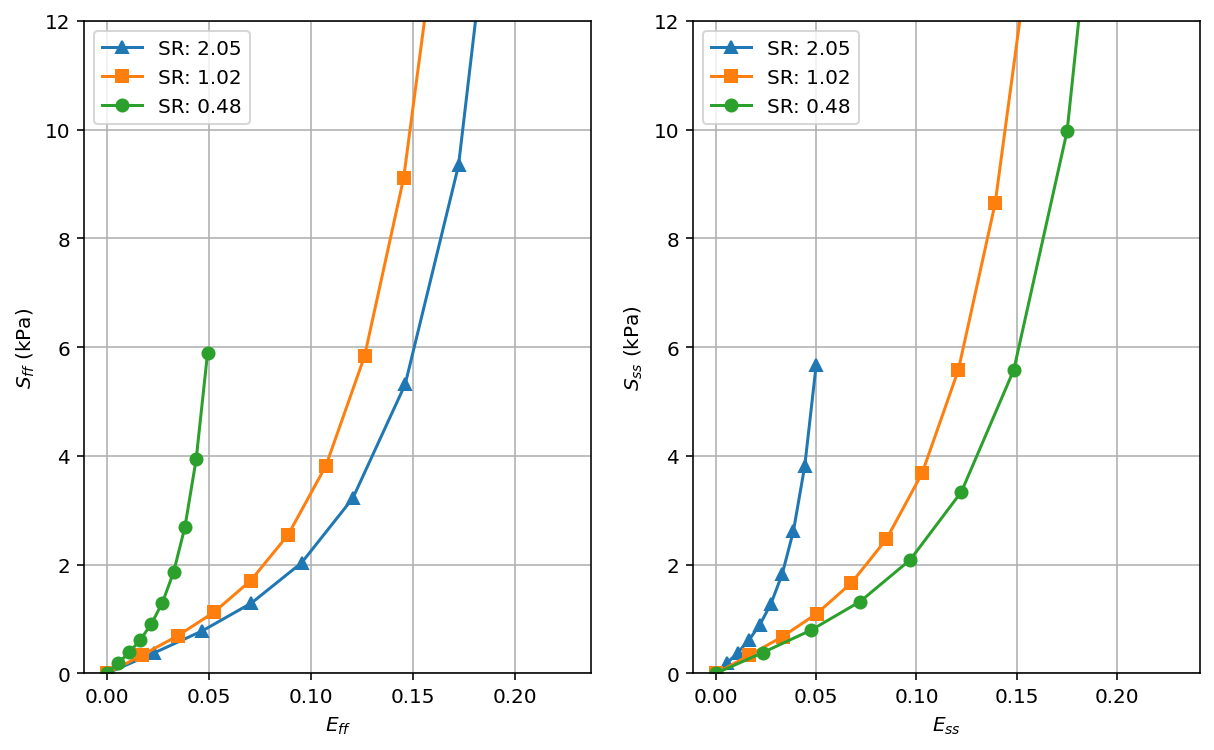

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
markers = ["^", "s", "o"]
for i, (sr, v) in enumerate(data.items()):
    ax[0].plot(v["Eff"], v["Sff"], marker=markers[i], label=f"SR: {sr:.2f}")
    ax[1].plot(v["Ess"], v["Sss"], marker=markers[i], label=f"SR: {sr:.2f}")
ax[0].set_ylabel("$S_{ff}$ (kPa)")
ax[1].set_ylabel("$S_{ss}$ (kPa)")
ax[0].set_xlabel("$E_{ff}$")
ax[1].set_xlabel("$E_{ss}$")
for axi in ax:
    axi.legend()
    axi.set_ylim(0, 12)
    axi.grid()
plt.show()